# Recurrent Neural Networks


In [1]:
import torch
import numpy as np
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Extract the data

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# path = "/content/drive/Shareddrives/G5/project-4-sentiment-classification/"
path = "./"
train_data = pd.read_csv(path + "train.csv")
test_data = pd.read_csv(path + "test.csv")

print(train_data.shape)
print(test_data.shape)
train_data.head()

(25000, 2)
(25000, 1)


,message,label
0,I saw this movie in NEW York city. I was waiti...,neg
1,This is a German film from 1974 that is someth...,neg
2,I attempted watching this movie twice and even...,neg
3,On his birthday a small boys tells his mother ...,neg
4,"The person who wrote the review ""enough with t...",pos


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\jeffr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token.lower() not in stop_words]
    return ' '.join(tokens)

In [6]:
train_data['tokens'] = train_data['message'].apply(preprocess_text)
test_data['tokens'] = test_data['message'].apply(preprocess_text)

In [13]:
train_data.head()

,message,label,tokens,vectors
0,I saw this movie in NEW York city. I was waiti...,0,saw movie new york city waiting bus next morni...,"[[-0.21996641, 0.17705941, -0.0033930233, -0.6..."
1,This is a German film from 1974 that is someth...,0,german film something woman come castle beyond...,"[[-0.46728015, 0.27693665, -0.29466736, -0.378..."
2,I attempted watching this movie twice and even...,0,attempted watching movie twice even fast forwa...,"[[-0.12267326, -0.110086754, 0.07383823, 0.421..."
3,On his birthday a small boys tells his mother ...,0,birthday small boy tell mother son want go hom...,"[[0.0073563126, 0.34156787, -0.5304753, -0.314..."
4,"The person who wrote the review ""enough with t...",1,person wrote review enough sweating spitting a...,"[[-0.0344274, 0.1957269, -0.32643205, 0.307864..."


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()  
train_data['label'] = label_encoder.fit_transform(train_data['label'])

In [8]:
from gensim.models import Word2Vec

sentences = train_data['tokens'].apply(lambda x: x.split()).to_list()
word2vec = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=1)

sentences_test = test_data['tokens'].apply(lambda x: x.split()).to_list()
word2vec_test = Word2Vec(sentences=sentences_test, vector_size=100, window=5, min_count=1, sg=1)

In [16]:
word2vec.wv.most_similar("like", topn=5)

[('creepier', 0.7893841862678528),
 ('hmmmm', 0.7754266262054443),
 ('preteen', 0.7654963135719299),
 ('alot', 0.7647897005081177),
 ('anyways', 0.7632929086685181)]

In [9]:
def sentence_to_vectors(sentence, model, vector_size=100):
    vectors = []
    for word in sentence.split():
        if word in model.wv:
            vectors.append(model.wv[word])
        else:
            vectors.append([0] * vector_size)
    return np.array(vectors)

In [10]:
train_data['vectors'] = train_data['tokens'].apply(lambda x: sentence_to_vectors(x, word2vec))
test_data['vectors'] = test_data['tokens'].apply(lambda x: sentence_to_vectors(x, word2vec_test))

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(train_data['tokens']).toarray()
X_test_tfidf = list(vectorizer.transform(test_data['tokens']).toarray())

In [12]:
max_len = max(train_data['tokens'].apply(lambda text: len(text.split())))
mean_len = int(round(np.mean(train_data['tokens'].apply(lambda text: len(text.split())))))

print(f'Max length: {max_len}')
print(f'Mean length: {mean_len}')

Max length: 1421
Mean length: 119


In [13]:
def pad_sentences(vectors, max_len, vector_size=100):
    if len(vectors) > max_len:
        vectors = vectors[:max_len]
    else:
        padding = np.zeros((max_len - len(vectors), vector_size))
        vectors = np.vstack([vectors, padding])
    return torch.tensor(vectors, dtype=torch.float32)

In [14]:
train_data['tensor'] = train_data['vectors'].apply(lambda x: pad_sentences(x, mean_len, word2vec.vector_size))
test_data['tensor'] = test_data['vectors'].apply(lambda x: pad_sentences(x, mean_len, word2vec_test.vector_size))

In [113]:
train_data.head()

,message,label,tokens,vectors,tfidf,tensor
0,I saw this movie in NEW York city. I was waiti...,0,saw movie new york city waiting bus next morni...,"[[0.17053513, 0.044531778, -0.5490574, -0.4508...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[tensor(0.1705), tensor(0.0445), tensor(-0.54..."
1,This is a German film from 1974 that is someth...,0,german film something woman come castle beyond...,"[[-0.2837934, 0.1716008, -0.071153946, -0.3870...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[tensor(-0.2838), tensor(0.1716), tensor(-0.0..."
2,I attempted watching this movie twice and even...,0,attempted watching movie twice even fast forwa...,"[[-0.015660213, 0.0361225, 0.23330258, 0.34803...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[tensor(-0.0157), tensor(0.0361), tensor(0.23..."
3,On his birthday a small boys tells his mother ...,0,birthday small boy tell mother son want go hom...,"[[0.16865695, 0.36055747, -0.49575418, -0.3732...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[tensor(0.1687), tensor(0.3606), tensor(-0.49..."
4,"The person who wrote the review ""enough with t...",1,person wrote review enough sweating spitting a...,"[[-0.079325594, 0.27384898, 0.07582834, 0.3497...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[tensor(-0.0793), tensor(0.2738), tensor(0.07..."


In [67]:
X_wtov = torch.stack(train_data['tensor'].tolist())
X_tfidf = torch.tensor(X_train_tfidf, dtype=torch.float32)
y = torch.tensor(train_data['label'].values)

print(X_wtov.shape)
print(y.shape)
print(X_tfidf.shape)

torch.Size([25000, 119, 100])
torch.Size([25000])
torch.Size([25000, 5000])


## Models

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, type_='wtov'):
        super(LSTM, self).__init__()
        self.type_ = type_
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        if self.type_ == 'tfidf':
            x = x.unsqueeze(1)
        _, (hidden, _) = self.lstm(x)  
        hidden = hidden[-1]
        out = self.fc(hidden)
        return out

In [48]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.rnn(x) 
        hidden = hidden[-1] 
        out = self.fc(hidden)
        return out

In [49]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        _, hidden = self.gru(x)
        hidden = hidden[-1]
        out = self.fc(hidden)
        return out

## Training Function
This function is designed to train all three models efficiently and streamline the process for the user.

In [174]:
def train(model, optimizer, loss_f, num_epochs, train_loader):
    losses = []
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for inputs, labels in train_loader:
            labels = labels.long()
            outputs = model(inputs)
            loss = loss_f(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}")
    
    return losses

## Evaluate Accuracy Function

In [82]:
# def evaluate(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#     accuracy = correct / total
#     return accuracy


def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []        
    all_predictions = [] 
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            # inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total

    return accuracy, all_labels, all_predictions

## Dividing the data

### Word 2 Vec

In [55]:
from torch.utils.data import DataLoader, TensorDataset, random_split

dataset_wtov = TensorDataset(X_wtov, y)

train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader_wtov = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader_wtov = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader_wtov)) 
print(len(test_loader_wtov)) 

625
157


### TF-IDF

In [68]:
dataset_tfidf = TensorDataset(X_tfidf, y)

train_dataset_tfidf, test_dataset_tfidf = random_split(dataset_tfidf, [train_size, test_size])

batch_size = 32
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=batch_size, shuffle=False)

print(len(train_loader_tfidf))
print(len(test_loader_tfidf))

625
157


## Train the models

### LSTM

#### Word2Vec

Experiment with the hyperparameters

In [95]:
# Función de búsqueda en cuadrícula de hiperparámetros
def grid_search(param_grid):
    best_accuracy = 0
    best_params = {}

    # Iterar sobre todas las combinaciones posibles de hiperparámetros
    for hidden_size in param_grid['hidden_size']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for num_epochs in param_grid['num_epochs']:

                    # Crear DataLoader con el tamaño de batch actual
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

                    # Inicializar el modelo LSTM con los parámetros actuales
                    model = LSTM(input_size=100, hidden_size=hidden_size, output_size=2)

                    # Inicializar la función de pérdida y el optimizador
                    loss_function_LSTM = torch.nn.CrossEntropyLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                    # # Entrenar el modelo
                    # print(f"Entrenando con hidden_size={hidden_size}, num_layers={num_layers}, "
                    #         f"learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}")
                    losses = train(model, optimizer, loss_function_LSTM, num_epochs, train_loader)

                    # Evaluar el modelo
                    accuracy, _, _ = evaluate(model, test_loader)
                    print(f"Accuracy con hidden_size={hidden_size}, learning_rate={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs}: {accuracy * 100:.2f}%")

                    # Guardar la mejor configuración
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params = {
                            'hidden_size': hidden_size,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'num_epochs': num_epochs
                        }
    
    return best_accuracy, best_params

In [96]:
# Parámetros para la búsqueda en cuadrícula
param_grid = {
    'hidden_size': [64, 128, 256],              # Diferentes tamaños de la capa oculta
    'learning_rate': [0.001, 0.0005, 0.0001],   # Diferentes tasas de aprendizaje
    'batch_size': [64, 128],                    # Tamaño del batch
    'num_epochs': [10, 20, 30]                  # Número de épocas para entrenar
}

# Realizar búsqueda en cuadrícula
best_accuracy, best_params = grid_search(param_grid)

# Imprimir los mejores parámetros y la precisión
print(f"\nMejores parámetros: {best_params}")
print(f"Mejor Accuracy: {best_accuracy * 100:.2f}%")

Accuracy con hidden_size=64, learning_rate=0.001, batch_size=64, num_epochs=10: 85.56%
Accuracy con hidden_size=64, learning_rate=0.001, batch_size=64, num_epochs=20: 86.76%
Accuracy con hidden_size=64, learning_rate=0.001, batch_size=64, num_epochs=30: 86.54%
Accuracy con hidden_size=64, learning_rate=0.001, batch_size=128, num_epochs=10: 77.46%
Accuracy con hidden_size=64, learning_rate=0.001, batch_size=128, num_epochs=20: 86.74%
Accuracy con hidden_size=64, learning_rate=0.001, batch_size=128, num_epochs=30: 85.78%
Accuracy con hidden_size=64, learning_rate=0.0005, batch_size=64, num_epochs=10: 84.70%
Accuracy con hidden_size=64, learning_rate=0.0005, batch_size=64, num_epochs=20: 53.90%
Accuracy con hidden_size=64, learning_rate=0.0005, batch_size=64, num_epochs=30: 85.86%
Accuracy con hidden_size=64, learning_rate=0.0005, batch_size=128, num_epochs=10: 54.26%
Accuracy con hidden_size=64, learning_rate=0.0005, batch_size=128, num_epochs=20: 86.28%
Accuracy con hidden_size=64, lear

Testing with best Hyperparameters

In [ ]:
num_epochs = 10
learning_rate = 0.001
input_size_w2v = 100 # word2vec.vector_size
hidden_size = 128
output_size = 2
num_layers = 1  

input_size_tfidf = 5000 # X_tfidf.shape[1]

# num_epochs = best_params['num_epochs']
# learning_rate = best_params['learning_rate']
# input_size_w2v = 100 # word2vec.vector_size
# hidden_size = best_params['hidden_size']
# batch_size = best_params['batch_size']
# output_size = 2
# num_layers = 1  

# train_loader_wtov = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader_wtov = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# input_size_tfidf = 5000 # X_tfidf.shape[1]

In [175]:
lstm = LSTM(input_size_w2v, hidden_size, output_size, num_layers)
loss_function_LSTM = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

losses_w2v_lstm = train(lstm, optimizer, loss_function_LSTM, num_epochs, train_loader_wtov)

print(losses_w2v_lstm)

Epoch 1/30, Loss: 0.6822928310202333
Epoch 2/30, Loss: 0.6749649981911571
Epoch 3/30, Loss: 0.6748955795368828
Epoch 4/30, Loss: 0.6741439753447097
Epoch 5/30, Loss: 0.6708131935268926
Epoch 6/30, Loss: 0.6357719034623033
Epoch 7/30, Loss: 0.6512413084887849
Epoch 8/30, Loss: 0.6562978317752813
Epoch 9/30, Loss: 0.6754323537357318
Epoch 10/30, Loss: 0.6793715771013936
Epoch 11/30, Loss: 0.6422667365295057
Epoch 12/30, Loss: 0.6792931629065126
Epoch 13/30, Loss: 0.6933708348975014
Epoch 14/30, Loss: 0.66743991283563
Epoch 15/30, Loss: 0.6265930302988607
Epoch 16/30, Loss: 0.648325292732769
Epoch 17/30, Loss: 0.5246225122255258
Epoch 18/30, Loss: 0.40192280009912607
Epoch 19/30, Loss: 0.35094482125565646
Epoch 20/30, Loss: 0.34145964463107503
Epoch 21/30, Loss: 0.3237839684890101
Epoch 22/30, Loss: 0.31795908486881197
Epoch 23/30, Loss: 0.31397024720621564
Epoch 24/30, Loss: 0.30787064254093477
Epoch 25/30, Loss: 0.3054917052911874
Epoch 26/30, Loss: 0.3021538995515805
Epoch 27/30, Loss:

#### TF-IDF

In [75]:
lstm_tfidf = LSTM(input_size_tfidf, hidden_size, output_size, num_layers, type_='tfidf')
loss_function_LSTM = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_tfidf.parameters(), lr=learning_rate)

losses_tfidf_lstm = train(lstm_tfidf, optimizer, loss_function_LSTM, num_epochs, train_loader_tfidf)

print(losses_tfidf_lstm)

Epoch 1/10, Loss: 0.3834376544117927
Epoch 2/10, Loss: 0.22949714483618736
Epoch 3/10, Loss: 0.19746896969676017
Epoch 4/10, Loss: 0.1799872969508171
Epoch 5/10, Loss: 0.1644196824491024
Epoch 6/10, Loss: 0.15171217764914036
Epoch 7/10, Loss: 0.14024721548855304
Epoch 8/10, Loss: 0.12736473506987095
Epoch 9/10, Loss: 0.11307105800509452
Epoch 10/10, Loss: 0.09872271286398172
[0.3834376544117927, 0.22949714483618736, 0.19746896969676017, 0.1799872969508171, 0.1644196824491024, 0.15171217764914036, 0.14024721548855304, 0.12736473506987095, 0.11307105800509452, 0.09872271286398172]


### RNN

#### Word2Vec

In [78]:
rnn = RNN(input_size, hidden_size, output_size, num_layers)
loss_function_RNN = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
losses_w2v_rnn = train(rnn, optimizer, loss_function_RNN, num_epochs, train_loader)

print(losses_w2v_rnn)

Epoch 1/10, Loss: 0.6807526525497436
Epoch 2/10, Loss: 0.6984385432243347
Epoch 3/10, Loss: 0.6887064885139466
Epoch 4/10, Loss: 0.688634882068634
Epoch 5/10, Loss: 0.6846405459403991
Epoch 6/10, Loss: 0.6861972051620483
Epoch 7/10, Loss: 0.6857281202316284
Epoch 8/10, Loss: 0.6881315352439881
Epoch 9/10, Loss: 0.6821457111358643
Epoch 10/10, Loss: 0.6746736751556397
[0.6807526525497436, 0.6984385432243347, 0.6887064885139466, 0.688634882068634, 0.6846405459403991, 0.6861972051620483, 0.6857281202316284, 0.6881315352439881, 0.6821457111358643, 0.6746736751556397]


#### TF-IDF

#### Experiment with the hyperparameters

### GRU

#### Word2Vec

In [79]:
gru = GRU(input_size, hidden_size, output_size, num_layers)
loss_function_GRU = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)
losses_w2v_gru = train(gru, optimizer, loss_function_GRU, num_epochs, train_loader)

print(losses_w2v_gru)

Epoch 1/10, Loss: 0.6593920402050019
Epoch 2/10, Loss: 0.6683498323440552
Epoch 3/10, Loss: 0.4005159907341003
Epoch 4/10, Loss: 0.3268043298125267
Epoch 5/10, Loss: 0.3097068729043007
Epoch 6/10, Loss: 0.2995392607450485
Epoch 7/10, Loss: 0.29028844405412674
Epoch 8/10, Loss: 0.2838325895428658
Epoch 9/10, Loss: 0.275965496468544
Epoch 10/10, Loss: 0.26738104411959646
[0.6593920402050019, 0.6683498323440552, 0.4005159907341003, 0.3268043298125267, 0.3097068729043007, 0.2995392607450485, 0.29028844405412674, 0.2838325895428658, 0.275965496468544, 0.26738104411959646]


#### TF-IDF

#### Experiment with the hyperparameters

## Test the models and metrics

### LSTM

In [176]:
accuracy_w2v_lstm, labels_w2v_lstm, predictions_w2c_lstm = evaluate(lstm, test_loader_wtov)
print(f'Accuracy LSTM word2vec: {accuracy_w2v_lstm * 100:.2f}%')

accuracy_tfidf_lstm, labels_tfidf_lstm, predictions_tfidf_lstm = evaluate(lstm_tfidf, test_loader_tfidf)
print(f'Accuracy LSTM tfidf: {accuracy_tfidf_lstm * 100:.2f}%')

Accuracy LSTM word2vec: 86.70%
Accuracy LSTM tfidf: 84.66%


Accuracy: 0.8670
Classification Report:
              precision    recall  f1-score   support

         neg       0.90      0.82      0.86      2523
         pos       0.83      0.91      0.87      2477

    accuracy                           0.86      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.87      0.86      0.86      5000



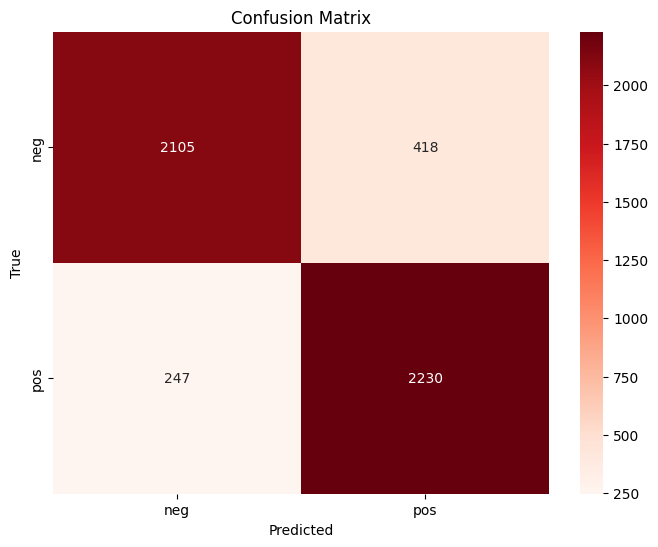

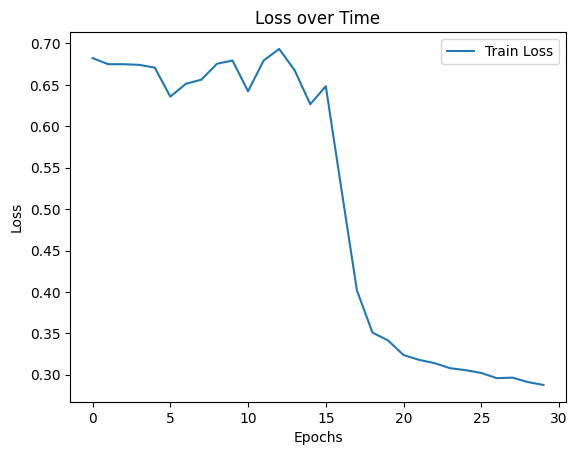

In [178]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy_w2v_lstm = accuracy_score(labels_w2v_lstm, predictions_w2c_lstm)
class_report_w2v_lstm = classification_report(labels_w2v_lstm, predictions_w2c_lstm, target_names=label_encoder.classes_)
cm_w2v_lstm = confusion_matrix(labels_w2v_lstm, predictions_w2c_lstm)

print(f'Accuracy: {accuracy_w2v_lstm:.4f}')
print('Classification Report:')
print(class_report)

# Graficar la matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_w2v_lstm, annot=True, fmt='d', cmap='Reds', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Graficar la pérdida a lo largo del tiempo
plt.plot(losses_w2v_lstm, label='Train Loss')
plt.title('Loss over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [139]:
len(data['accuracy'])

54

C:\Users\jeffr\AppData\Local\Temp\ipykernel_15864\3060315513.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


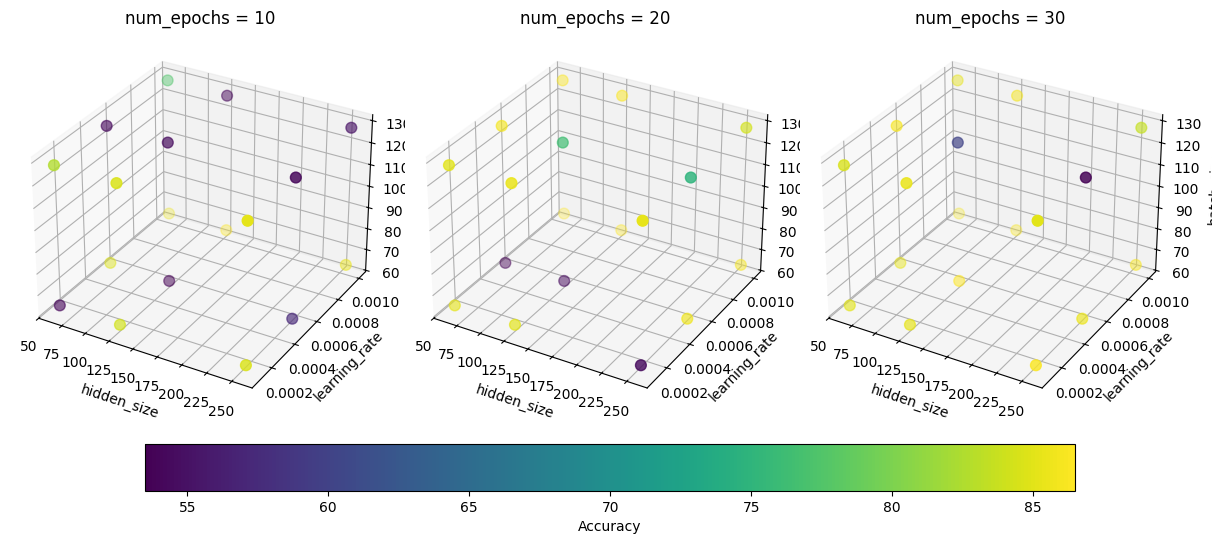

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Datos (como ejemplo, usa los datos que proporcionaste)
data = {
    'hidden_size': [
        64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256
    ],
    'learning_rate': [
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 
        0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 
        0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001
    ],
    'batch_size': [
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64,
        128, 128, 128, 
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64, 
        128, 128, 128, 
        64, 64, 64,
        128, 128, 128,
        64, 64, 64,
        128, 128, 128,
    ],
    'num_epochs': [
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30,
        10, 20, 30, 
        10, 20, 30, 
        10, 20, 30, 
    ],
    'accuracy': [
        85.56, 86.76, 86.54, 77.46, 86.74, 85.78, 84.70, 53.90, 85.86, 54.26, 
        86.28, 86.58, 53.96, 85.48, 85.54, 82.62, 85.42, 85.08, 86.48, 86.88, 
        86.74, 54.08, 86.68, 86.54, 53.50, 54.74, 87.10, 54.28, 76.80, 
        60.06, 84.26, 85.42, 85.88, 84.58, 85.80, 85.96, 85.44, 86.40, 
        86.80, 55.02, 84.62, 84.08, 57.18, 86.02, 86.16, 53.98, 75.34, 
        53.18, 84.58, 54.76, 86.84, 85.18, 85.64, 85.62
    ]
}


# Crear DataFrame
df = pd.DataFrame(data)

# Filtrar por valores de num_epochs
df_10 = df[df['num_epochs'] == 10]
df_20 = df[df['num_epochs'] == 20]
df_30 = df[df['num_epochs'] == 30]

# Crear la figura para los 3 gráficos
fig = plt.figure(figsize=(12, 18))  # Ajustar tamaño de la figura


# Primer gráfico para num_epochs = 10
ax1 = fig.add_subplot(231, projection='3d')
sc1 = ax1.scatter(df_10['hidden_size'], df_10['learning_rate'], df_10['batch_size'], c=df_10['accuracy'], cmap='viridis', s=60)
ax1.set_xlabel('hidden_size')
ax1.set_ylabel('learning_rate')
ax1.set_zlabel('batch_size')
ax1.set_title('num_epochs = 10')

# Segundo gráfico para num_epochs = 20
ax2 = fig.add_subplot(232, projection='3d')
sc2 = ax2.scatter(df_20['hidden_size'], df_20['learning_rate'], df_20['batch_size'], c=df_20['accuracy'], cmap='viridis', s=60)
ax2.set_xlabel('hidden_size')
ax2.set_ylabel('learning_rate')
ax2.set_zlabel('batch_size')
ax2.set_title('num_epochs = 20')

# Tercer gráfico para num_epochs = 30
ax3 = fig.add_subplot(233, projection='3d')
sc3 = ax3.scatter(df_30['hidden_size'], df_30['learning_rate'], df_30['batch_size'], c=df_30['accuracy'], cmap='viridis', s=60)
ax3.set_xlabel('hidden_size')
ax3.set_ylabel('learning_rate')
ax3.set_zlabel('batch_size')
ax3.set_title('num_epochs = 30')

# Ajustar el layout de los gráficos
# plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)

# Añadir barra de colores común a los tres gráficos, y moverla a la parte inferior
cbar = fig.colorbar(sc1, ax=[ax1, ax2, ax3], orientation='horizontal', pad=-0.7)
cbar.set_label('Accuracy')

# Ajustar el layout y mostrar
plt.tight_layout()
plt.show()


### RNN

In [85]:
accuracy_w2v_rnn, labels_w2v_rnn, predictions_w2c_rnn = evaluate(rnn, test_loader_wtov)
print(f'Accuracy RNN word2vec: {accuracy_w2v_rnn * 100:.2f}%')

Accuracy RNN word2vec: 54.72%


### GRU

In [86]:
accuracy_w2v_gru, labels_w2v_gru, predictions_w2c_gru = evaluate(gru, test_loader_wtov)
print(f'Accuracy GRU word2vec: {accuracy_w2v_gru * 100:.2f}%')

Accuracy GRU word2vec: 88.80%
